In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
from sklearn.ensemble import ExtraTreesClassifier
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import warnings
warnings.filterwarnings("ignore")
from clean_data import *
import os
from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.model_selection import train_test_split
from sklearn.metrics import make_scorer, f1_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

%matplotlib inline

# Exploratory Data Analysis

After crawling the data, we had 950 samples. Firstly, we noted that salaries are in different forms: some are based on hour/year, while some are in a range such as 70-80 an hour, etc. Therefore, we converted them into yearly-based salaries.

In [2]:
job_salary = pd.read_csv("data.csv")
job_salary.salary

0      $36.45 - $43.04 an hour
1                  $43 an hour
2                  $28 an hour
3                  $46 an hour
4               $34.50 an hour
                ...           
945          $70 - $80 an hour
946            $120,000 a year
947             $40.35 an hour
948             $40.10 an hour
949                $35 an hour
Name: salary, Length: 950, dtype: object

In [3]:
job_salary = pd.read_csv("data.csv")
job_salary_cleaned = clean_requirements(job_salary)
job_salary_cleaned = convert_salary(job_salary)
job_salary_cleaned.salary

0      100157.4
1      108360.0
2       70560.0
3      115920.0
4       86940.0
         ...   
945    189000.0
946    120000.0
947    101682.0
948    101052.0
949     88200.0
Name: salary, Length: 950, dtype: float64

## Distribution of the salary



 We observed that most salaries are in between 50K to 100K, which agree with our intuition. 

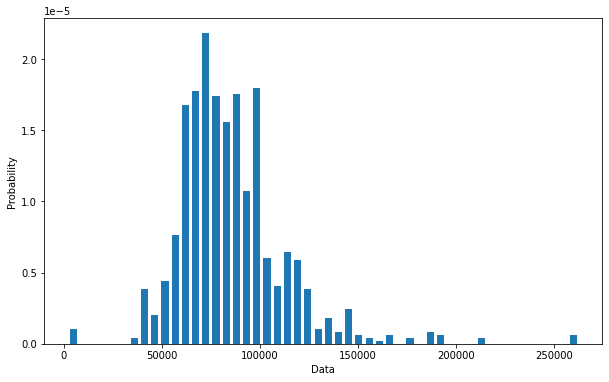

In [4]:
salary = job_salary_cleaned.salary.tolist()
plt.figure(figsize=(10,6))
plt.hist(salary,density=True, bins=50,rwidth=0.7)
plt.ylabel('Probability')
plt.xlabel('Data') 
plt.show()

Next, We split the salaries into five ranges: <50K, 50-75K, 75-100K, 100-150K, >150K.

In [5]:
# divide salary into 5 buckets
def salary_bucket(salary):
    if salary < 50000:
        return '<50,000'
    if salary >= 50000 and salary < 75000:
        return '50,000-75,000'
    elif salary >= 75000 and salary < 100000:
        return '75,000-100,000'
    elif salary >=100000 and salary <= 150000:
        return '10,0000-15,0000'
    else:
        return '>150,000'
    
job_salary_cleaned['salary_buckets'] = job_salary_cleaned['salary'].apply(lambda x: salary_bucket(x))

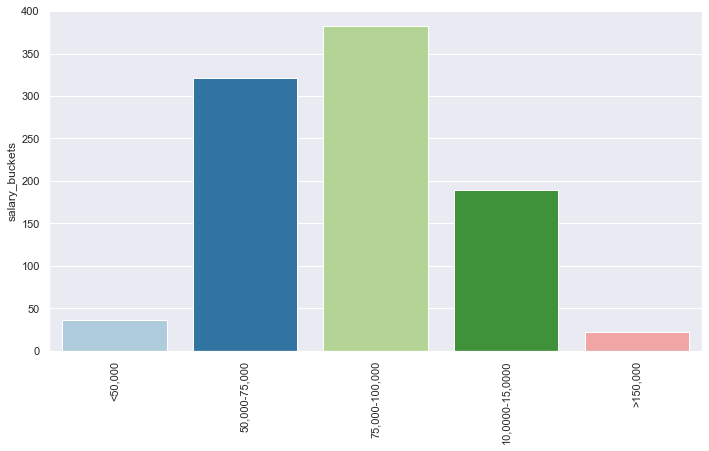

In [6]:
buckets_count = job_salary_cleaned['salary_buckets'].value_counts()
# distribution of classes
# [3, 1, 0, 2, 4] is used to list classes in ascending order
sns.set(rc={'figure.figsize':(11.7,6.27)}) 
sns.barplot(x=buckets_count.index[[3,1,0,2,4]], y=buckets_count[[3,1,0,2,4]], palette="Paired")
plt.xticks(rotation=90)
plt.show()

## Preliminary analysis

Before building models, we would like to have a preliminary analysis on the feautres. 

We could get a sense about how these features affect the salary by doing basic visualization.

### Location feature

For each province and city we calculated average salaries. We observed that the average salary is different in each province. ON and BC provinces have higher salaries than other ones. In addition, average salary of remote jobs is the highest.

However, the difference of salaries among provinces is not very obvious. Instead, we looked at the average salary on each city. The difference is now obvious with some cities having average salary higher than 100K and some lower than 60K.




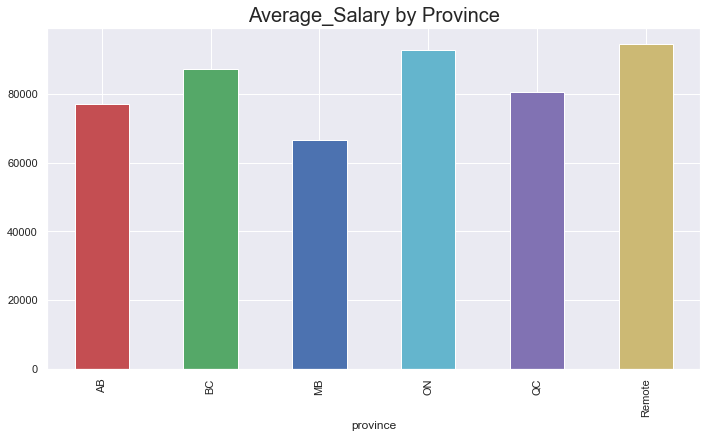

In [7]:
data = job_salary_cleaned
data = clean_location(data)
my_colors = 'rgbcmyk' 
mean_salary = data.groupby(['province']).mean()
mean_salary.plot(kind='bar',color=my_colors,legend=False)
plt.title("Average_Salary by Province", fontsize =20)
plt.show()

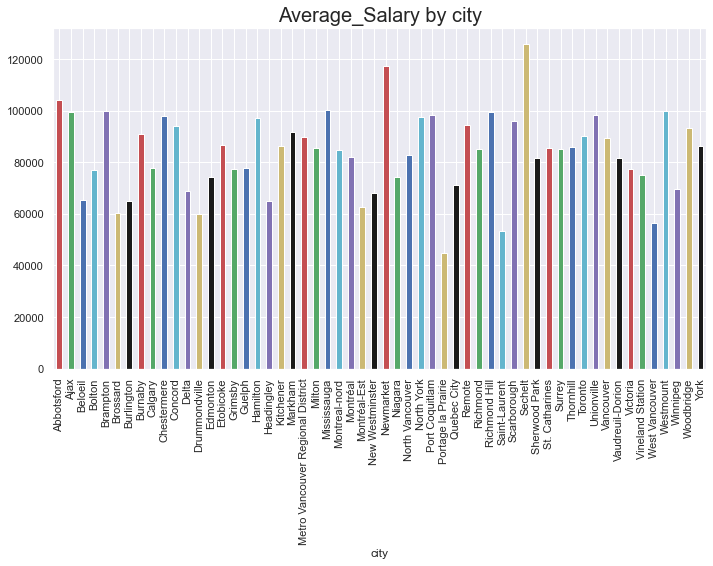

In [8]:
mean_salary = data.groupby(['city']).mean()
mean_salary.plot(kind='bar',color=my_colors,legend=False)
plt.title("Average_Salary by city", fontsize =20)
plt.show()

### Job requirements feature



In order to extract features from requirement text, we needed nature language processing (NLP) method to handle with text data. Term frequency-inverse document frequency (TF-IDF) is one of the popular NLP methods, which can reflect how important a word is to a document in a corpus. Compared to bag of words, another popular NLP method, TF-IDF reduces the importance of some frequently occurring terms like we, need or have which may not be included in stop words. If a term appears in every observation, it has no contribution to the model. Thus, we decided to use TF-IDF to extract features. In python, sklearn library has a function called TFidfVectorizer. It can calculate TF-IDF of terms in each document. Because some bigrams like machine learning or deep learning may be important to predict the salary, we extracted both unigram and bigram at the same time, and we only selected top 1,000 features. If we included all features, the dimension would be too large due to small data amount. 

The following two images show top 50 words in selected features. 

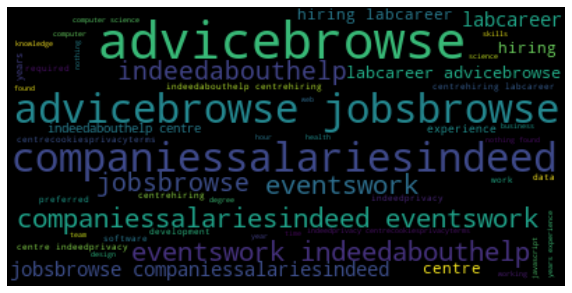

In [9]:
# extract features
vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_features=1000)
corpus = data['requirements_cleaned'].values
grams = vectorizer.fit_transform(corpus)
feature_names = vectorizer.get_feature_names()
words_df = pd.DataFrame(grams.toarray(), columns=feature_names)

amount = words_df.sum(axis=0)
top50 = amount.nlargest(50)
df = top50.to_frame().reset_index()
df.columns = ['word', 'count']
words = dict(zip(df['word'].tolist(), df['count'].tolist()))

wc = WordCloud().generate_from_frequencies(words)

plt.figure(figsize=(10, 10))
plt.imshow(wc,interpolation='bilinear')
plt.axis('off')
plt.show()

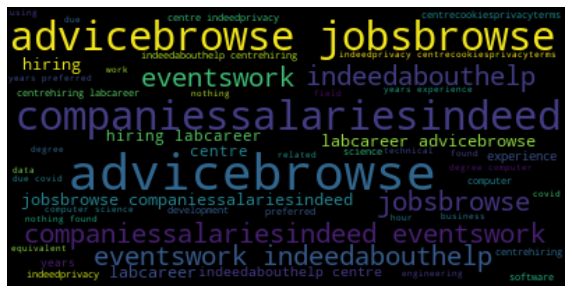

In [10]:
high_salary = data.loc[data['salary'] >100000]
# extract features
vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_features=1000)
corpus = high_salary['requirements_cleaned'].values
grams = vectorizer.fit_transform(corpus)
feature_names = vectorizer.get_feature_names()
words_df = pd.DataFrame(grams.toarray(), columns=feature_names)

amount = words_df.sum(axis=0)
top50 = amount.nlargest(50)
df = top50.to_frame().reset_index()
df.columns = ['word', 'count']
words = dict(zip(df['word'].tolist(), df['count'].tolist()))
wc = WordCloud().generate_from_frequencies(words)

plt.figure(figsize=(10, 10))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()

They are pretty similar no matter if the condition salary > 10K is added or not. The words like advicebrowse, companiessalariesindeed, eventswork have large overall TF-IDF values in corpus but they don’t make any sense for job hunters. In this case, we need to build the models to explore the relationship between features and salary.

### Category feature
In the data crawling step, we crawled salaries for 5 different job categories. From the figure it is clear that most jobs are still related to software and development.

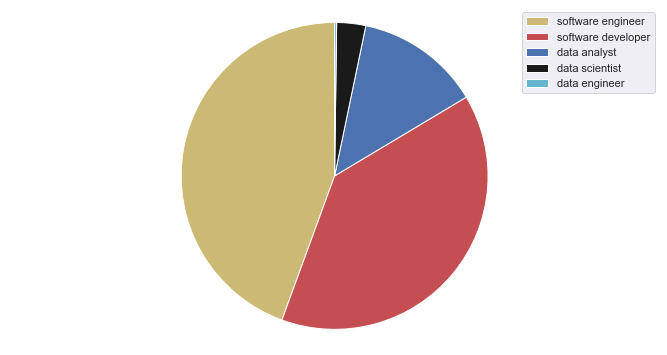

In [11]:
category = pd.DataFrame(job_salary['job_category'].value_counts()).reset_index()
category.columns = ['category', 'amount']
cat = category['category'] ; amount = category['amount']
colors = 'yrbkc' 

explode = (0, 0, 0, 0, 0)  
wedges, texts = plt.pie(amount, colors = colors, startangle=90, explode=explode)
plt.axis('equal') 
plt.legend(wedges, cat, loc="best")
plt.show()


Since there are not many examples of the job such as data scientist and data engineer, it is not very useful to compare the mean salary of different category, but from the scatter plots, we can still realize that most jobs from different categories are in the similar range.

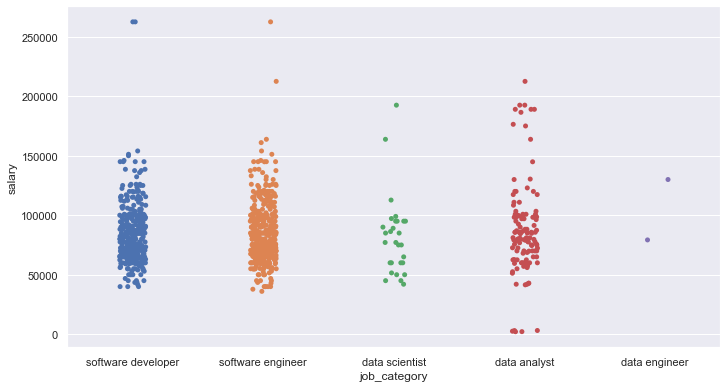

In [12]:
sns.stripplot(x="job_category", y="salary", data=job_salary_cleaned) 
plt.show()

## Model Selection

In the project, we tried logistic regression, K nearest neighbor, and random forest, which are three popular models to solve classification problems based on the 2019 Kaggle ML and Data Science Survey. Logistic regression, as a basic classification model, is commonly used in our work so we decided to use it as one of the models to predict salary according to extracted features. In the survey, the secondary popular algorithm is tree ensemble algorithm. In addition, random forest uses bootstrap method to build trees, which can reduce the impact of imbalanced data. 

Besides, it can compute the importance of features so we can know which skills affect the salary. The reason that we tried KNN is its power to solve multiclassification problems and easy to understand. In order to make sure the final model is generalized, we split the dataset into training set and test set as 80:20 ratio. For the evaluation metric, we chose weighted F1 score because the target has 5 imbalanced classes. 

Compared to regular macro F1 score, weighted F1 score takes the weighted average to the value. In this case, the impact between imbalanced classes is eliminated. Additionally, we used grid search and cross validation to tune hyperparameters. First, we used job category, location and 1000 extracted features to build the models. 

### Models including job_category and location

In [13]:
# drop useless columns
full_data = clean_location(job_salary_cleaned)
mod_data = full_data.drop(columns=['job_title', 'company_name', 'requirements', 'industry', 'requirements_cleaned'])
mod_data = pd.get_dummies(data=mod_data, columns=['job_category','city', 'province'])
mod_data =mod_data.drop(columns=['salary', 'salary_buckets'])

In [14]:
# extract features using TF-IDF
vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_features=1000)
corpus = full_data['requirements_cleaned'].values
grams = vectorizer.fit_transform(corpus)
feature_names = vectorizer.get_feature_names()
words_df = pd.DataFrame(grams.toarray(), columns=feature_names)

In [15]:
# split the data
X = pd.concat([mod_data, words_df], axis=1)
Y = full_data['salary_buckets']
xtrain, xtest, ytrain, ytest = train_test_split(X, Y, random_state=20, test_size=0.2)

In [16]:
# logistic regression
mod_log = LogisticRegression()
c = [0.01, 0.05, 0.1, 0.5, 1, 2, 5, 10, 20, 100, 200, 500, 1000]
parameters = {'C': c}
metric = make_scorer(f1_score, average='weighted')
grid_log = GridSearchCV(mod_log, parameters, scoring=metric, cv=5)
grid_log = grid_log.fit(xtrain, ytrain)
opt_log = grid_log.best_estimator_
# print("The optimal logistic regression model: \n", opt_log)
# print("====================================================================")
# print("The mean accuracy score is {0}.".format(grid_log.best_score_))

In [17]:
# KNN
mod_knn = KNeighborsClassifier()
neighbors = np.array(range(5, 50, 5))
parameters = {'n_neighbors': neighbors, 'weights': ['uniform', 'distance']}
metric = make_scorer(f1_score, average='weighted')
grid_knn = GridSearchCV(mod_knn, parameters, scoring=metric, cv=5)
grid_knn = grid_knn.fit(xtrain, ytrain)
opt_knn = grid_knn.best_estimator_
# print("The optimal SVM model: \n", opt_knn)
# print("====================================================================")
# print("The mean accuracy score is {0}.".format(grid_knn.best_score_))

In [18]:
# random forest
mod_rf = RandomForestClassifier(random_state=44)
numTrees = np.array(range(50, 500, 50))
parameters = {'n_estimators': numTrees}
metric = make_scorer(f1_score, average='weighted')
grid_rf = GridSearchCV(mod_rf, parameters, scoring=metric, cv=5)
grid_rf = grid_rf.fit(xtrain, ytrain)
opt_rf = grid_rf.best_estimator_
# print("The optimal random forest model: \n", opt_rf)
# print("====================================================================")
# print("The mean accuracy score is {0}.".format(grid_rf.best_score_))

In [19]:
score_df = pd.DataFrame(np.array([grid_log.best_score_, grid_knn.best_score_, grid_rf.best_score_]), 
                        columns=['F1 score'],
                        index=['Logistic Regression', 'KNN', 'Random Forest'])
score_df

,F1 score
Logistic Regression,0.671812
KNN,0.435024
Random Forest,0.646524


In [20]:
print("The weighted macro f1 score of the optimal logistic regression model on the test set is", 
      f1_score(ytest, opt_log.predict(xtest), average='weighted'), ".")

The weighted macro f1 socre of the optimal logistic regression model on the test set is 0.6791827294591143 .


By comparing their F1 score, we found that logistic regression model gave the highest score among these three models. On the training set, the score of logistic regression was 67.18%. On the test set, the score of the logistic regression was 67.92%. Its training score and test score are close, indicating no overfitting. 

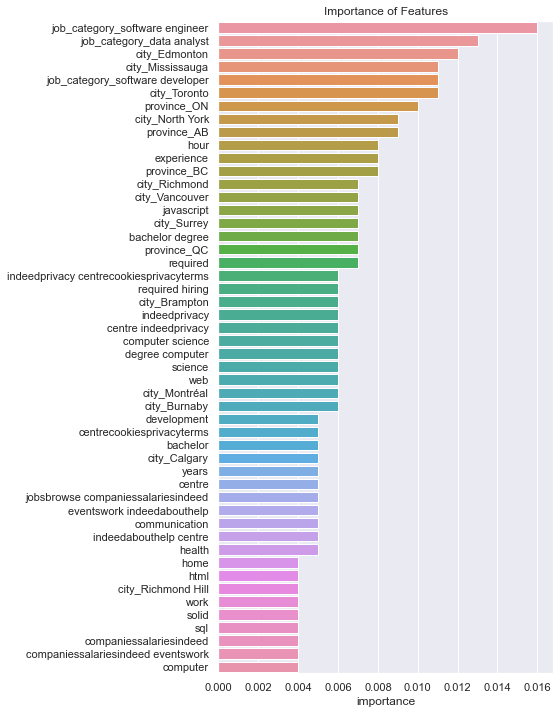

In [21]:
# visualize feature importance based on TF-IDF
# create feature importance data frame
df = pd.DataFrame(opt_rf.feature_importances_, columns=["importance"],
                  index=X.columns)
# sort by importance
df = df.sort_values('importance', ascending=False)
# plot top 20 features
plt.figure(figsize = (6,12))
sns.barplot(x=np.round(df.importance, 3)[0:50], y=df.index[0:50])
plt.title("Importance of Features")
plt.show()

However, when we looked the feature importance, we found the most top important features are job categories and locations, which make sense because the salary must be influenced by them. However, the aim of the project is to find which skills are important for job hunters. In this case, we decided to exclude job category and location when we fitted models. 

In [22]:
# # bulid a confusion matrix
# cm = confusion_matrix(ytest, opt_rf.predict(xtest), 
#                       labels=['<50,000', '50,000-75,000', '75,000-100,000', '100,000-150,000', '>150,000'])
# # plot the confusion matrix
# sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', 
#             xticklabels=['<50,000', '50,000-75,000', '75,000-100,000', '100,000-150,000', '>150,000'], 
#             yticklabels=['<50,000', '50,000-75,000', '75,000-100,000', '100,000-150,000', '>150,000'])
# plt.xlabel("Predicted Label")
# plt.ylabel("True Label")
# plt.title("Confusion Matrix for salary buckets")
# plt.show()

### Model selection excluding job_category and location

In [23]:
# when job_category and location are excluded
mod_data = full_data.drop(columns=['job_title', 'company_name', 'requirements', 'industry', 'requirements_cleaned'])
mod_data = mod_data.drop(columns=['job_category', 'city', 'province'])
mod_data =mod_data.drop(columns=['salary', 'salary_buckets'])

In [24]:
# split the data
X = pd.concat([mod_data, words_df], axis=1)
Y = full_data['salary_buckets']
xtrain, xtest, ytrain, ytest = train_test_split(X, Y, random_state=20, test_size=0.2)

In [25]:
# logistic regression
mod_log = LogisticRegression()
c = [0.01, 0.05, 0.1, 0.5, 1, 2, 5, 10, 20, 100, 200, 500, 1000]
parameters = {'C': c}
metric = make_scorer(f1_score, average='weighted')
grid_log = GridSearchCV(mod_log, parameters, scoring=metric, cv=5)
grid_log = grid_log.fit(xtrain, ytrain)
opt_log = grid_log.best_estimator_
# print("The optimal logistic regression model: \n", opt_log)
# print("====================================================================")
# print("The mean accuracy score is {0}.".format(grid_log.best_score_))

In [26]:
# KNN
mod_knn = KNeighborsClassifier()
neighbors = np.array(range(5, 50, 5))
parameters = {'n_neighbors': neighbors, 'weights': ['uniform', 'distance']}
metric = make_scorer(f1_score, average='weighted')
grid_knn = GridSearchCV(mod_knn, parameters, scoring=metric, cv=5)
grid_knn = grid_knn.fit(xtrain, ytrain)
opt_knn = grid_knn.best_estimator_
# print("The optimal SVM model: \n", opt_knn)
# print("====================================================================")
# print("The mean accuracy score is {0}.".format(grid_knn.best_score_))

In [27]:
# random forest
mod_rf = RandomForestClassifier(random_state=44)
numTrees = np.array(range(50, 500, 50))
parameters = {'n_estimators': numTrees}
metric = make_scorer(f1_score, average='weighted')
grid_rf = GridSearchCV(mod_rf, parameters, scoring=metric, cv=5)
grid_rf = grid_rf.fit(xtrain, ytrain)
opt_rf = grid_rf.best_estimator_
# print("The optimal random forest model: \n", opt_rf)
# print("====================================================================")
# print("The mean accuracy score is {0}.".format(grid_rf.best_score_))

In [28]:
score_df = pd.DataFrame(np.array([grid_log.best_score_, grid_knn.best_score_, grid_rf.best_score_]), 
                        columns=['F1 score'],
                        index=['Logistic Regression', 'KNN', 'Random Forest'])
score_df

,F1 score
Logistic Regression,0.654519
KNN,0.624966
Random Forest,0.650368


As shown in the table, compared to previous models, the scores of the new models slightly lowered but the logistic regression model still gave the highest score on the training set. 

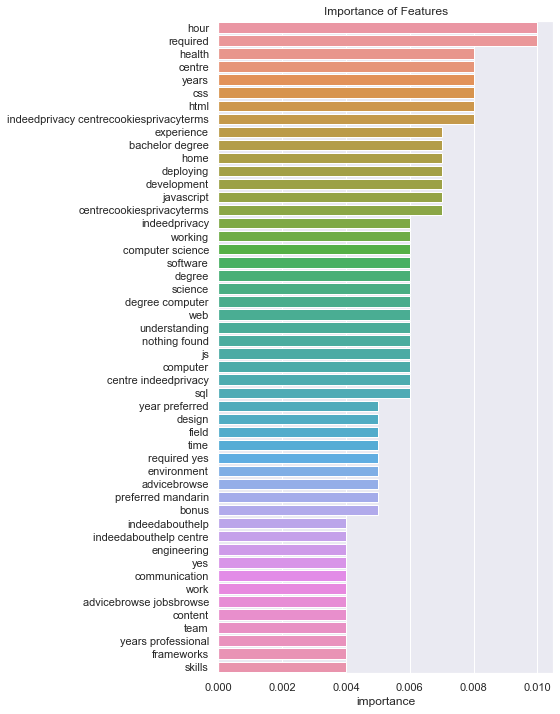

In [29]:
# visualize feature importance based on bag of wrods
# create feature importance data frame
df = pd.DataFrame(opt_rf.feature_importances_, columns=["importance"],
                  index=X.columns)
# sort by importance
df = df.sort_values('importance', ascending=False)
# plot top 20 features
plt.figure(figsize = (6,12))
sns.barplot(x=np.round(df.importance, 3)[0:50], y=df.index[0:50])
plt.title("Importance of Features")
plt.show()

In [30]:
print("The weighted macro f1 score of the optimal random forest model on the test set is", 
      f1_score(ytest, opt_log.predict(xtest), average='weighted'), ".")

The weighted macro f1 socre of the optimal random forest model on the test set is 0.653350443002876 .


When we looked the feature importance again, we found that programming languages such as javascript, html, sql, and css were important. Besides, the degree in computer science had a significant impact on the salary as well. Moreover, the score of the logistic regression model on the test set was 65.34%.

In [31]:
# # bulid a confusion matrix
# cm = confusion_matrix(ytest, opt_rf.predict(xtest), 
#                       labels=['<50,000', '50,000-75,000', '75,000-100,000', '100,000-150,000', '>150,000'])
# # plot the confusion matrix
# sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', 
#             xticklabels=['<50,000', '50,000-75,000', '75,000-100,000', '100,000-150,000', '>150,000'], 
#             yticklabels=['<50,000', '50,000-75,000', '75,000-100,000', '100,000-150,000', '>150,000'])
# plt.xlabel("Predicted Label")
# plt.ylabel("True Label")
# plt.title("Confusion Matrix for salary buckets")
# plt.show()

In [32]:
coef_matrix = opt_log.coef_
# get the index of 10 smallest coefficients 
index_smallest = [list(np.argsort(x)[:10]) for x in coef_matrix]
# get the index of 10 largest coefficients
index_largest = [list(np.argsort(-x)[:10]) for x in coef_matrix]
# create a data frame which contains features with the 10 smallest coefficients
smallest_feature_df = pd.DataFrame([X.columns[x] for x in index_smallest], index=opt_log.classes_)
# create a data frame which contains features with the 10 largest coefficients
largest_feature_df = pd.DataFrame([X.columns[x] for x in index_largest], index=opt_log.classes_)
# create a data frame which contains features' coefficients associated with smallest_feature_df
smallest_coef_df = pd.DataFrame([coef_matrix[x][index_smallest[x]] for x in range(len(index_smallest))], index=opt_log.classes_)
# create a data frame which contains features' coefficients associated with largest_feature_df
largest_coef_df = pd.DataFrame([coef_matrix[x][index_largest[x]] for x in range(len(index_largest))], index=opt_log.classes_)

In [33]:
smallest_feature_df

,0,1,2,3,4,5,6,7,8,9
"10,0000-15,0000",bonus,agile scrum,scrum,knowledge,casual,design,mysql,js,communication,testing
"50,000-75,000",dental,building,degree computer,facing,year preferred,django,including,ability,must,technology
"75,000-100,000",home,related,etc experience,ability work,developmentexperience,office,technologies,process,business,project
"<50,000",development,engineering,years,hiring,hiring labcareer,information,hour shiftmonday,software,using,writing
">150,000",years preferred,react,health,management,indeedabouthelp centrehiring,centrehiring,centrehiring labcareer,development years,time,shiftmonday


In [34]:
smallest_coef_df

,0,1,2,3,4,5,6,7,8,9
"10,0000-15,0000",-5.537386,-5.449267,-5.422638,-4.864413,-4.563615,-4.479798,-4.129897,-3.854206,-3.813630,-3.718879
"50,000-75,000",-5.210803,-4.813210,-4.344665,-4.258374,-4.141300,-3.954722,-3.928332,-3.902048,-3.882968,-3.801918
"75,000-100,000",-7.296871,-4.809430,-4.806181,-4.711514,-4.605810,-4.542210,-4.110027,-4.063157,-3.982561,-3.667043
"<50,000",-3.148126,-2.824971,-2.696012,-2.489458,-2.489259,-2.356741,-2.308186,-2.297799,-2.281446,-2.219745
">150,000",-2.948757,-2.190385,-2.110509,-1.958464,-1.717015,-1.717015,-1.717015,-1.673031,-1.624931,-1.618521


In [35]:
largest_feature_df

,0,1,2,3,4,5,6,7,8,9
"10,0000-15,0000",home,preferably,deploying,cloud,hour,eventsdental,shiftmonday,content,identity,manage
"50,000-75,000",mandarin,web,office,required yes,clients,js,required hiring,mysql,git,experienced
"75,000-100,000",bachelor degree,bachelor,bonus,en,development years,preferred,agile scrum,experience working,travel,date
"<50,000",care,dental,must,editing,comfortable,care hour,hour shift,one,space,record
">150,000",technical,years required,bi,design,year preferred,user,capabilities,computer based,secondary,required


In [36]:
largest_coef_df

,0,1,2,3,4,5,6,7,8,9
"10,0000-15,0000",6.903309,5.837550,5.292293,5.235494,4.679831,4.647512,4.557057,4.459683,4.416165,4.280178
"50,000-75,000",6.055229,5.514030,5.343124,5.301661,5.229200,5.194672,5.070667,4.897640,4.762430,4.406164
"75,000-100,000",7.032659,5.737761,5.413230,5.318233,4.886512,4.864827,4.857813,4.401871,4.204179,4.171346
"<50,000",5.511650,4.994520,4.983664,4.018811,3.840097,3.767147,3.713515,3.532246,3.455834,3.292877
">150,000",7.389142,5.965936,4.261527,3.829695,3.766348,3.706698,3.603912,3.115978,3.035591,2.810271


### Conclusion

We completed this project by three main steps:

(1) web scraping: To collect data, we wrote a web scraping program in Python and conduct unit tests to handle various types of information embedded in indeed website. To make scraping more effeciently, we only considered those jobs with salary feature. In total, we scraped six features for each job, including job title, job category, company name, job requirement, location and salary. Our job searching conditions ranged from 8 main cities in Canada and 5 different job titles. After that, we tidied those scattered information into a clear data frame for further processing.

(2) data visualization: Besides showing salaries distribution based on job categories and location, we utilized TF-IDF method to demonstrate popular key words within job requirements. This provided qualitative understanding of job features.

(3) model building: The core mission of this project is to predict salary based on job features. We considered three machine learning models as our candidates: logistic regression, KNN and random forest. To make overall comparison, we tried some scenarios and tune the model hyperparameters. The final evaluation showed that logistic regression outperformed other two models and achieved 65.34% on weighted F1 score. If we took a look for coefficents in final logistic regression model, it was intersting that front-end skills such as web and js had the most positive impacts on salary.

For future work, we could try scraping more data and testing other models. On the other hand, using domain knowledge to improve NLP method such as manually adding critical key words (machine learning, Python, etc..) might be another way to optimize our work.